# VAE Model Using Convolutional and MaxPooling Layers
Partition the physical data and define the model architecture.

In [9]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# GPU initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model hyperparameters
latent_dim = 512
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"model_at_{timestamp}"
model_weights_path = f'{folder}/model_weights_pytorch.pth'

# Custom callback equivalent for prediction evolution
class PredictionTracker:
    def __init__(self, encoder_model, decoder_model, initial_point, test_time, mean_psi, std_psi, actual_values, zonal_wind_idx=63):
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.initial_point = initial_point.clone()  # Use clone() instead of copy() for PyTorch tensors
        self.test_time = test_time
        print(f"Debug: self.test_time = {self.test_time}")
        self.mean_psi = mean_psi
        self.std_psi = std_psi
        self.predictions_history = []
        self.actual_values = actual_values
        self.zonal_wind_idx = zonal_wind_idx
        
    def on_epoch_end(self, epoch, train_loss, val_loss):
        print(f"Epoch {epoch + 1}: Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")
        
        self.encoder_model.eval()
        self.decoder_model.eval()
        
        pred_mean = np.zeros((self.test_time, 75, 1))
        initial = self.initial_point.clone()
        
        with torch.no_grad():
            for k in tqdm(range(self.test_time), desc=f"Epoch {epoch + 1} Prediction Progress"):
                try:
                    # Get latent encoding
                    mu, log_var = self.encoder_model(initial)
                    z = self.reparameterize(mu, log_var)
                    
                    # Decode
                    pred_ens = self.decoder_model(z)
                    
                    pred_step = pred_ens.cpu().numpy().reshape(75, 1)
                    pred_mean[k, :, :] = pred_step
                    
                    # Denormalize prediction (PyTorch version of the TF code)
                    pred_denorm = (pred_step.squeeze() * self.std_psi.cpu().numpy() + 
                                   self.mean_psi.cpu().numpy()).reshape(1, 75, 1)
                    
                    # Normalize again for next input
                    initial = torch.tensor(
                        (pred_denorm - self.mean_psi.cpu().numpy().reshape(1, -1, 1)) / 
                        self.std_psi.cpu().numpy().reshape(1, -1, 1),
                        dtype=torch.float32
                    ).to(device)
                    
                except Exception as e:
                    print(f"Error during prediction at day {k}: {e}")
                    break
        
        # Denormalize final predictions
        pred_mean = pred_mean.squeeze() * self.std_psi.cpu().numpy().reshape(1, -1) + self.mean_psi.cpu().numpy().reshape(1, -1)
        pred_mean = pred_mean.reshape(self.test_time, 75, 1)
        self.predictions_history.append(pred_mean)
        
        # Save predictions and plot
        np.save(f'{folder}/predictions_epoch_{epoch+1}.npy', pred_mean)
        plt.figure(figsize=(15, 10))
        plt.plot(self.actual_values[:, self.zonal_wind_idx], 'b-', label='Actual', linewidth=2)
        plt.plot(pred_mean[:, self.zonal_wind_idx], 'r--', label=f'Predicted', linewidth=2)
        plt.title(f'Predictions vs Actual at Epoch {epoch+1}')
        plt.xlabel('Days')
        plt.ylabel('Zonal Wind Speed')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{folder}/prediction_epoch_{epoch+1}.png')
        plt.close()
        
        # Return models to training mode
        self.encoder_model.train()
        self.decoder_model.train()
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def plot_prediction_evolution(predictions_history, actual_values, zonal_wind_idx=63):
    n_epochs = len(predictions_history)
    plt.figure(figsize=(15, 10))
    plt.plot(actual_values[:, zonal_wind_idx], 'k-', label='Actual', linewidth=2)
    
    for i, pred in enumerate(predictions_history):
        alpha = (i + 1) / n_epochs
        plt.plot(pred[:, zonal_wind_idx], alpha=alpha, 
                label=f'Epoch {i+1}', linestyle='--')
    
    plt.title(f'Evolution of Predictions at Index {zonal_wind_idx}')
    plt.xlabel('Days')
    plt.ylabel('Zonal Wind Speed')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder}/prediction_evolution.png')
    plt.show()

# Define PyTorch VAE model classes
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers with pooling (equivalent to TF model)
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        
        # Calculate flattened size - original shape is (75, 1)
        # After 3 pooling layers: 75 -> 38 -> 19 -> 9 (slightly different from TF due to PyTorch pooling)
        self.flattened_size = 9 * 64
        
        # Latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        
    def forward(self, x):
        # PyTorch expects [batch_size, channels, length] for Conv1d
        # So we need to permute from [batch_size, length, channels]
        x = x.permute(0, 2, 1)
        
        # Apply convolution and pooling layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Get latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        # First reshape from latent space to match encoder's flattened shape
        self.latent_to_features = nn.Linear(latent_dim, 10 * 64)
        
        # Transpose convolutions (equivalent to upsampling + conv in TensorFlow)
        self.tconv1 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.tconv2 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2) 
        self.tconv3 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)
        
        # Final output layer
        self.tconv_final = nn.ConvTranspose1d(64, 1, kernel_size=3, padding=1)
        
    def forward(self, z):
        # Reshape from latent dimension
        x = torch.relu(self.latent_to_features(z))
        x = x.view(-1, 64, 10)  # Reshape to [batch, channels, length]
        
        # Apply transpose convolutions with upsampling
        x = torch.relu(self.tconv1(x))
        x = self.upsample1(x)
        x = torch.relu(self.tconv2(x))
        x = self.upsample2(x)
        x = torch.relu(self.tconv3(x))
        x = self.upsample3(x)
        
        # Final layer and crop to match input shape (75, 1)
        x = self.tconv_final(x)
        x = x[:, :, :75]  # Crop to ensure correct output size
        
        # Convert back to [batch, length, channels] format
        x = x.permute(0, 2, 1)
        
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var
    
    def loss_function(self, recon_x, x, mu, log_var, beta=5):
        """
        Calculates VAE loss = reconstruction loss + KL divergence loss
        """
        # Reconstruction loss (MSE)
        recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='mean')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with beta weighting for KL term
        return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Load and preprocess data (similar to TF code)
F = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')
psi = F[3500:, 0, :]

# Normalize data
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
std_psi = np.maximum(std_psi, 1e-8) # Stop gradient explosion
psi = (psi - mean_psi) / std_psi

# Data preparation (same as TF code)
train_size = 220000
val_size = 50000
test_time = 30000
lead = 1

# Define indices for splitting
train_end = train_size
val_start = train_end
val_end = val_start + val_size

# Training data
psi_input_Tr = psi[:train_end, :].reshape(-1, 75, 1)
psi_label_Tr = psi[:train_end, :].reshape(-1, 75, 1)

# Validation data
psi_input_val = psi[val_start:val_end, :].reshape(-1, 75, 1)
psi_label_val = psi[val_start + lead:val_end + lead, :].reshape(-1, 75, 1)

# Test set size (10% of the dataset)
test_size = int(0.1 * psi.shape[0])

# Define test inputs and labels
psi_test_input = psi[val_end:val_end + test_size, :].reshape(-1, 75, 1)
psi_test_label = psi[val_end + lead:val_end + lead + test_size, :].reshape(-1, 75, 1)

# Define initial point for inference
initial_point = psi[val_end, :].reshape(1, 75, 1)

# Actual values corresponding to the test set for plotting
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)

print(f"Shape of psi: {psi.shape}")
print(f"Train input shape: {psi_input_Tr.shape}")
print(f"Train label shape: {psi_label_Tr.shape}")
print(f"Validation input shape: {psi_input_val.shape}")
print(f"Validation label shape: {psi_label_val.shape}")
print(f"Test input shape: {psi_test_input.shape}")
print(f"Test label shape: {psi_test_label.shape}")
print(f"Initial point shape: {initial_point.shape}")

psi_input_Tr_tensor = torch.FloatTensor(psi_input_Tr).to(device)
psi_label_Tr_tensor = torch.FloatTensor(psi_label_Tr).to(device)
psi_input_val_tensor = torch.FloatTensor(psi_input_val).to(device)
psi_label_val_tensor = torch.FloatTensor(psi_label_val).to(device)
psi_test_input_tensor = torch.FloatTensor(psi_test_input).to(device)
psi_test_label_tensor = torch.FloatTensor(psi_test_label).to(device)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)

# DataLoaders
train_dataset = TensorDataset(psi_input_Tr_tensor, psi_label_Tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

val_dataset = TensorDataset(psi_input_val_tensor, psi_label_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

mean_psi_tensor = torch.FloatTensor(mean_psi).to(device)
std_psi_tensor = torch.FloatTensor(std_psi).to(device)

# Initialize
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters())
torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

# Early stopping
best_val_loss = float('inf')
patience = 20
patience_counter = 0

# Prediction tracker
pred_tracker = PredictionTracker(
    vae.encoder, 
    vae.decoder, 
    initial_point_tensor, 
    test_time, 
    mean_psi_tensor, 
    std_psi_tensor, 
    actual_values, 
    zonal_wind_idx=63
)

# Training loop
def train_epoch(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    recon_loss_sum = 0
    kl_loss_sum = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, log_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_sum += recon_loss.item()
        kl_loss_sum += kl_loss.item()
    
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss_sum / len(train_loader)
    avg_kl_loss = kl_loss_sum / len(train_loader)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.6f}, Recon Loss = {avg_recon_loss:.6f}, KL Loss = {avg_kl_loss:.6f}")
    return avg_loss

def validate(model, val_loader):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            recon_batch, mu, log_var = model(data)
            loss, _, _ = model.loss_function(recon_batch, target, mu, log_var)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss = {avg_val_loss:.6f}")
    return avg_val_loss

Using device: cuda
Shape of psi: (306200, 75)
Train input shape: (220000, 75, 1)
Train label shape: (220000, 75, 1)
Validation input shape: (50000, 75, 1)
Validation label shape: (50000, 75, 1)
Test input shape: (30620, 75, 1)
Test label shape: (30620, 75, 1)
Initial point shape: (1, 75, 1)
Debug: self.test_time = 30000


# Train the Model
## Plot / Save out the predictions at each epoch
At each epoch there are weights that are saved out. Using those weights make an inference given the set amount of time. Find the weight with the least amount of loss and save it out as the "best model".

No pre-trained weights found. Training model...


Epoch 1 Training: 100%|██████████| 215/215 [00:06<00:00, 32.60it/s]


Epoch 1: Train Loss = 0.340839, Recon Loss = 0.242680, KL Loss = 0.019632


Validation: 100%|██████████| 49/49 [00:00<00:00, 66.48it/s]


Validation Loss = 0.258926
Epoch 1: Loss = 0.340839, Validation Loss = 0.258926


Epoch 1 Prediction Progress: 100%|██████████| 30000/30000 [00:48<00:00, 624.29it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 1.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 2 Training: 100%|██████████| 215/215 [00:05<00:00, 37.17it/s]


Epoch 2: Train Loss = 0.225727, Recon Loss = 0.123381, KL Loss = 0.020469


Validation: 100%|██████████| 49/49 [00:00<00:00, 71.89it/s]


Validation Loss = 0.245470
Epoch 2: Loss = 0.225727, Validation Loss = 0.245470


Epoch 2 Prediction Progress: 100%|██████████| 30000/30000 [00:46<00:00, 649.84it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 2.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 3 Training: 100%|██████████| 215/215 [00:05<00:00, 36.54it/s]


Epoch 3: Train Loss = 0.213809, Recon Loss = 0.112149, KL Loss = 0.020332


Validation: 100%|██████████| 49/49 [00:00<00:00, 60.90it/s]


Validation Loss = 0.240538
Epoch 3: Loss = 0.213809, Validation Loss = 0.240538


Epoch 3 Prediction Progress: 100%|██████████| 30000/30000 [00:46<00:00, 645.06it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 3.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 4 Training: 100%|██████████| 215/215 [00:06<00:00, 35.01it/s]


Epoch 4: Train Loss = 0.206249, Recon Loss = 0.105407, KL Loss = 0.020168


Validation: 100%|██████████| 49/49 [00:00<00:00, 69.25it/s]


Validation Loss = 0.230490
Epoch 4: Loss = 0.206249, Validation Loss = 0.230490


Epoch 4 Prediction Progress: 100%|██████████| 30000/30000 [00:45<00:00, 652.50it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 4.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 5 Training: 100%|██████████| 215/215 [00:05<00:00, 36.11it/s]


Epoch 5: Train Loss = 0.192882, Recon Loss = 0.095187, KL Loss = 0.019539


Validation: 100%|██████████| 49/49 [00:00<00:00, 51.12it/s]


Validation Loss = 0.214130
Epoch 5: Loss = 0.192882, Validation Loss = 0.214130


Epoch 5 Prediction Progress: 100%|██████████| 30000/30000 [10:26<00:00, 47.91it/s]  


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 5.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 6 Training: 100%|██████████| 215/215 [00:05<00:00, 36.55it/s]


Epoch 6: Train Loss = 0.174400, Recon Loss = 0.082623, KL Loss = 0.018355


Validation: 100%|██████████| 49/49 [00:00<00:00, 58.49it/s]


Validation Loss = 0.197371
Epoch 6: Loss = 0.174400, Validation Loss = 0.197371


Epoch 6 Prediction Progress: 100%|██████████| 30000/30000 [00:47<00:00, 637.93it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 6.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 7 Training: 100%|██████████| 215/215 [00:05<00:00, 36.64it/s]


Epoch 7: Train Loss = 0.152903, Recon Loss = 0.071281, KL Loss = 0.016324


Validation: 100%|██████████| 49/49 [00:00<00:00, 70.95it/s]


Validation Loss = 0.178627
Epoch 7: Loss = 0.152903, Validation Loss = 0.178627


Epoch 7 Prediction Progress: 100%|██████████| 30000/30000 [00:52<00:00, 574.15it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 7.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 8 Training: 100%|██████████| 215/215 [00:08<00:00, 26.63it/s]


Epoch 8: Train Loss = 0.136603, Recon Loss = 0.061635, KL Loss = 0.014994


Validation: 100%|██████████| 49/49 [00:00<00:00, 54.90it/s]


Validation Loss = 0.167164
Epoch 8: Loss = 0.136603, Validation Loss = 0.167164


Epoch 8 Prediction Progress: 100%|██████████| 30000/30000 [01:04<00:00, 462.29it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 8.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 9 Training: 100%|██████████| 215/215 [00:08<00:00, 24.39it/s]


Epoch 9: Train Loss = 0.126285, Recon Loss = 0.053475, KL Loss = 0.014562


Validation: 100%|██████████| 49/49 [00:00<00:00, 49.49it/s]


Validation Loss = 0.160295
Epoch 9: Loss = 0.126285, Validation Loss = 0.160295


Epoch 9 Prediction Progress: 100%|██████████| 30000/30000 [01:08<00:00, 434.82it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 9.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


Epoch 10 Training: 100%|██████████| 215/215 [00:09<00:00, 22.31it/s]


Epoch 10: Train Loss = 0.120121, Recon Loss = 0.048768, KL Loss = 0.014271


Validation: 100%|██████████| 49/49 [00:01<00:00, 29.47it/s]


Validation Loss = 0.155486
Epoch 10: Loss = 0.120121, Validation Loss = 0.155486


Epoch 10 Prediction Progress: 100%|██████████| 30000/30000 [01:21<00:00, 367.68it/s]


Model weights saved to model_at_2025-03-19_13-30-59.927247 with point 10.
Model weights saved to model_at_2025-03-19_13-30-59.927247 for the best model.


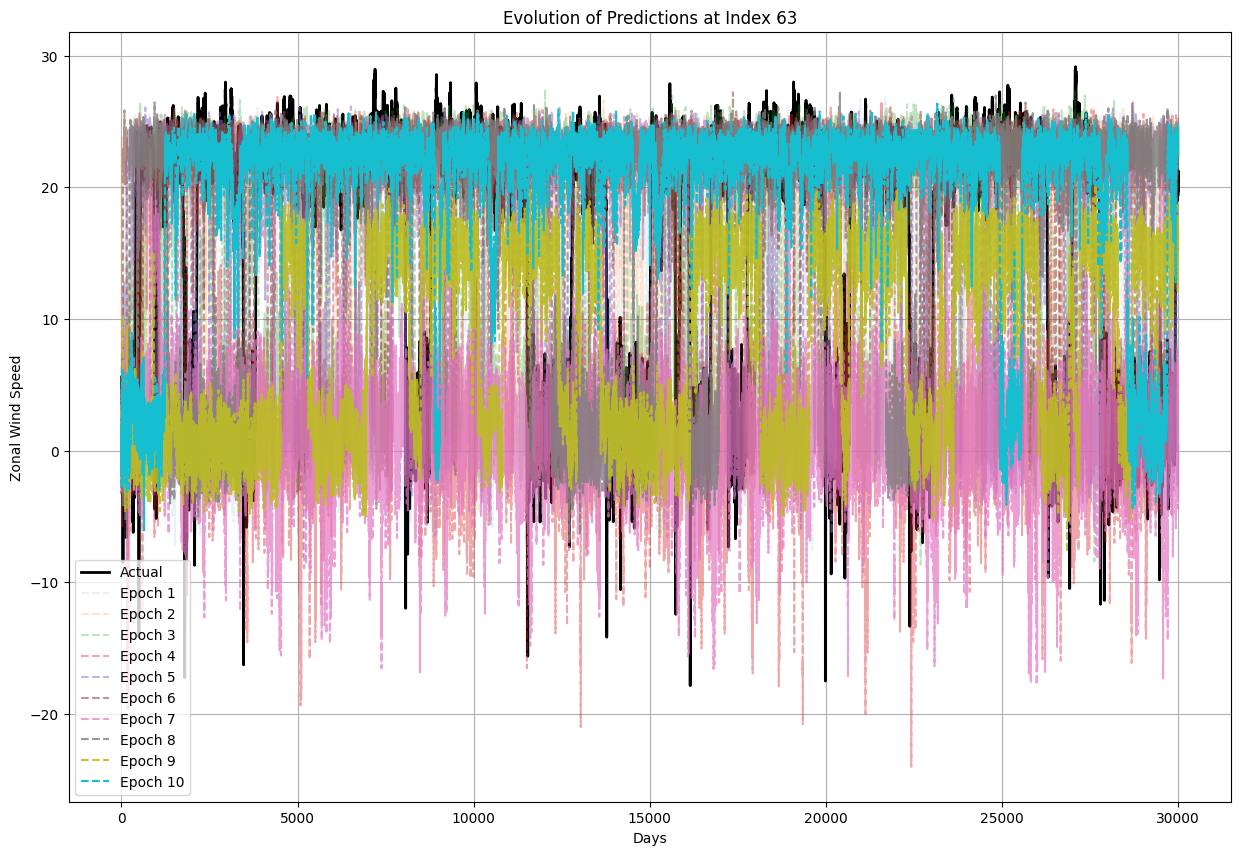


Starting inference...


Inference Progress: 100%|██████████| 30000/30000 [01:32<00:00, 324.71it/s]



Mean Squared Error: 84.75131713588793


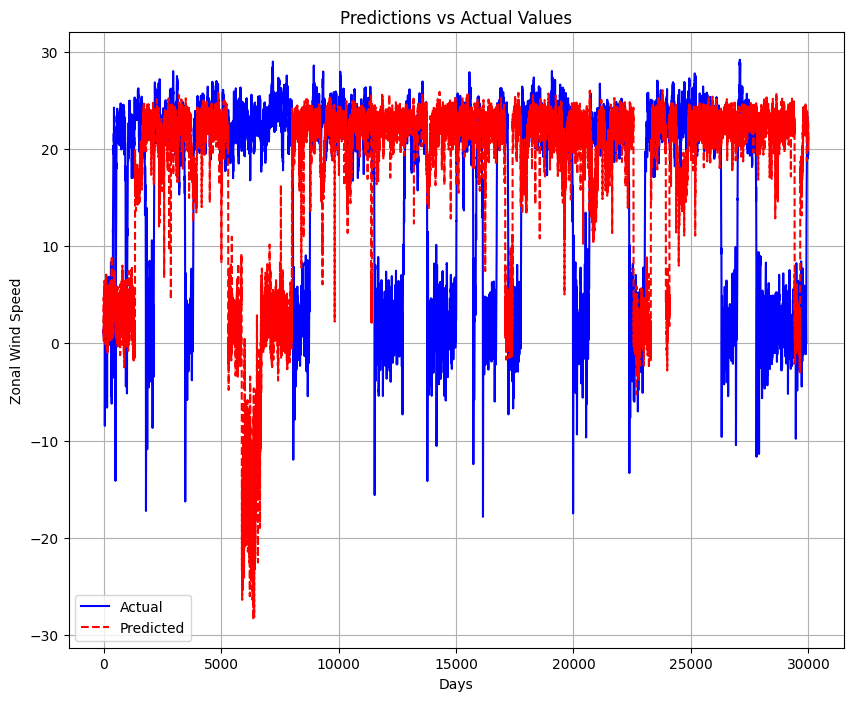

Could not load or plot training history: [Errno 2] No such file or directory: 'train_loss.npy'


In [10]:
# Training process
train_losses = []
val_losses = []
num_epochs = 10

# Check if pre-trained weights exist
if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")
else:
    print(f"No pre-trained weights found. Training model...")
    
    os.makedirs(folder)

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss = train_epoch(vae, train_loader, optimizer, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_loss = validate(vae, val_loader)
        val_losses.append(val_loss)
        
        # Run prediction tracking
        pred_tracker.on_epoch_end(epoch, train_loss, val_loss)
        
        # Checkpoint per epoch

        torch.save(vae.state_dict(), f"{folder}/checkpoint_{epoch+1}")
        print(f"Model weights saved to {folder} with point {epoch+1}.")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(vae.state_dict(), f"{folder}/best_model")
            print(f"Model weights saved to {folder} for the best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Save loss history for plotting
    np.save(f'{folder}train_loss.npy', np.array(train_losses))
    np.save(f'{folder}val_loss.npy', np.array(val_losses))

# Plot prediction evolution if predictions were tracked
if pred_tracker.predictions_history:
    plot_prediction_evolution(pred_tracker.predictions_history, actual_values, 63)

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()

# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
    with torch.no_grad():
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
pred_flat = pred_mean.reshape(test_time, 75)
actual_flat = actual_values
mse_value = mean_squared_error(actual_flat, pred_flat)
print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(10, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig(f'{folder}/predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, f'{folder}/model_results.pt')

# Plot training history if available
try:
    train_loss = np.load('train_loss.npy')
    val_loss = np.load('val_loss.npy')
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Loss vs Epochs')
    plt.savefig(f'{folder}/loss_plot.png')
    plt.show()
except Exception as e:
    print(f"Could not load or plot training history: {e}")

# Separate inference
Make a singular inference using the "best_model" weights. It's possible to change which weights you use based on the model_weights_path variable.

- Modify "test_time" based on the amount of time steps required

Model weights loaded from C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-03-19_13-30-59.927247\best_model.

Starting inference...
(20000, 75, 1)
(20000, 75)


Inference Progress: 100%|██████████| 20000/20000 [00:51<00:00, 387.19it/s]



Mean Squared Error: 76.73943915110486


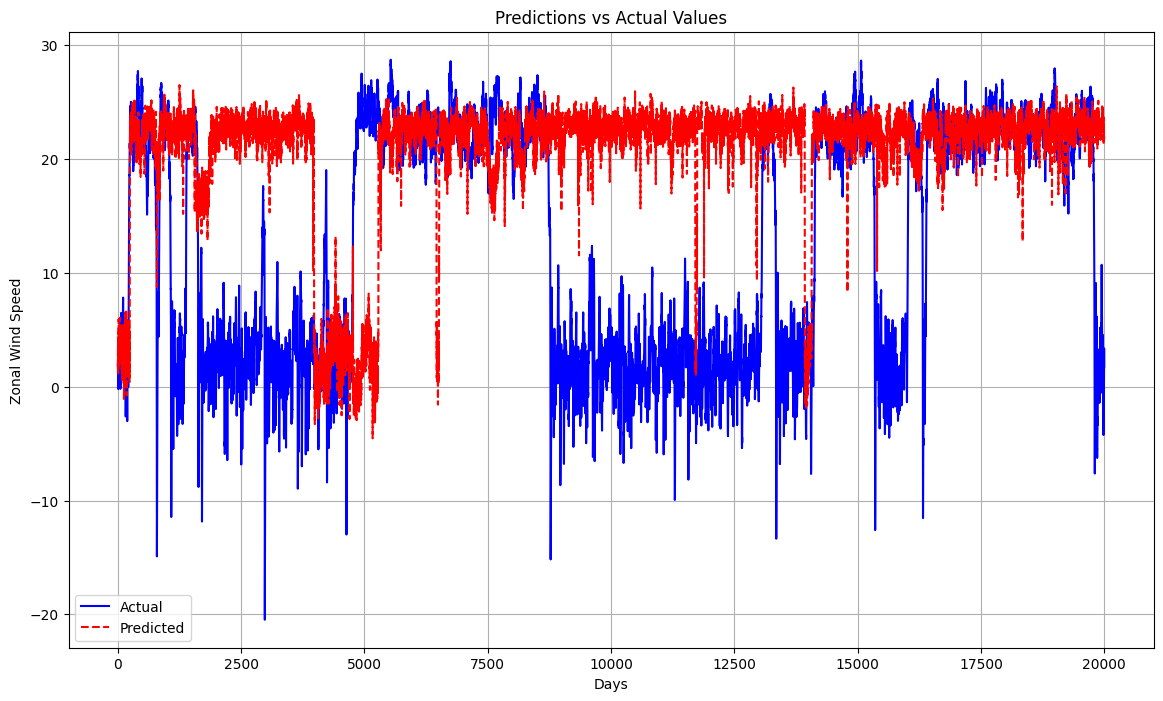

In [13]:
model_weights_path = r"C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-03-19_13-30-59.927247\best_model"

test_time = 20000

if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()
initial_point = psi[0, :].reshape(1, 75, 1)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)
psi_test_label = psi[:, :].reshape(-1, 75, 1)
print(psi_test_label[:test_time, :, :].shape)
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)
print(actual_values.shape)
# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
# No gradient tracking needed for inference
    with torch.no_grad():
        # Set initial point
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            
            if torch.isnan(pred_step).any():
                print(f"NaN detected at day {k}")
                print(f"mu values: {mu}")
                print(f"log_var values: {log_var}")
                print(f"z values: {z}")
                break

            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
pred_flat = pred_mean.reshape(test_time, 75)
actual_flat = actual_values
mse_value = mean_squared_error(actual_flat, pred_flat)
print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(14, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig('predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, 'model_results.pt')

np.save(f'predictions_checkpoint_38.npy', pred_mean)

# Testing the Predictive Model

## Overview
This section outlines our testing strategy to validate the accuracy, robustness, and reliability of our predictive model. Rigorous testing is critical to ensure that our model performs well under various tests.
Set flags to 1 based on which metric(s) you would like to test.

In the next cell are the flags and some basic parameters.

In [46]:
#FLAGS to determine testing
plot_data = 1
#what level do you want to plot
level = 61
CCDF = 1
Bi_modal_distribution = 1
single_step_profiles = 1
#for the single_step_profiles
left_limit, right_limit = 20000, 30000
time_step = 22000
if (time_step < left_limit or time_step > right_limit):
    raise Exception (f"Current time step must be within the range: {left_limit} and {right_limit}")

There are two paths here that you will manually set. One to the physical data and the other to the predictions. 
# WARNING
Unless you're running new tests...
Do not run this cell multiple times after testing as it will create a new folder based on your current time!

In [47]:
#Initialize Data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")
predictions = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\predictions_main.npy")

#reshape the predictions so that it matches the real_data shape
predictions = predictions.reshape(300000, 1, 75)
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'CCDF', 'Bi_modal_distribution', 'single_step_profiles']
profiles = ['im_psi', 'real_psi', 'zonal_wind']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
    if (subfolder == 'single_step_profiles'):
        for profile in profiles:
            subpath = os.path.join(path, profile)
            os.mkdir(subpath)


(300000, 1, 75)
(309700, 2, 75)
Created subfolder: testing_at_2025-03-19_18-26-45.162837\timeseries
Created subfolder: testing_at_2025-03-19_18-26-45.162837\CCDF
Created subfolder: testing_at_2025-03-19_18-26-45.162837\Bi_modal_distribution
Created subfolder: testing_at_2025-03-19_18-26-45.162837\single_step_profiles


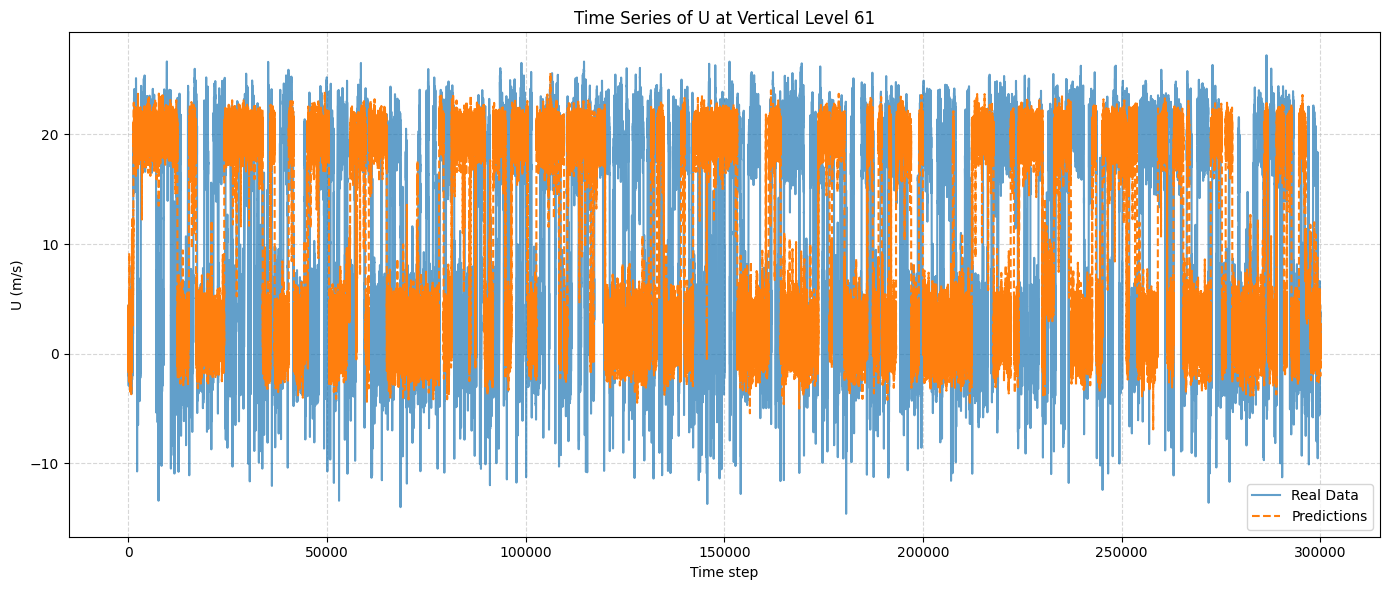

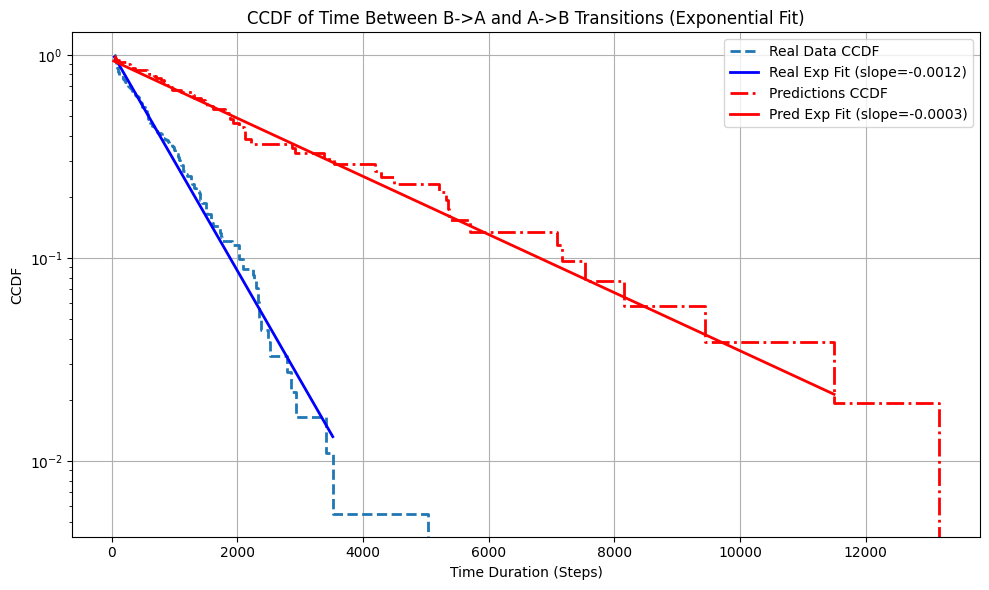

Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


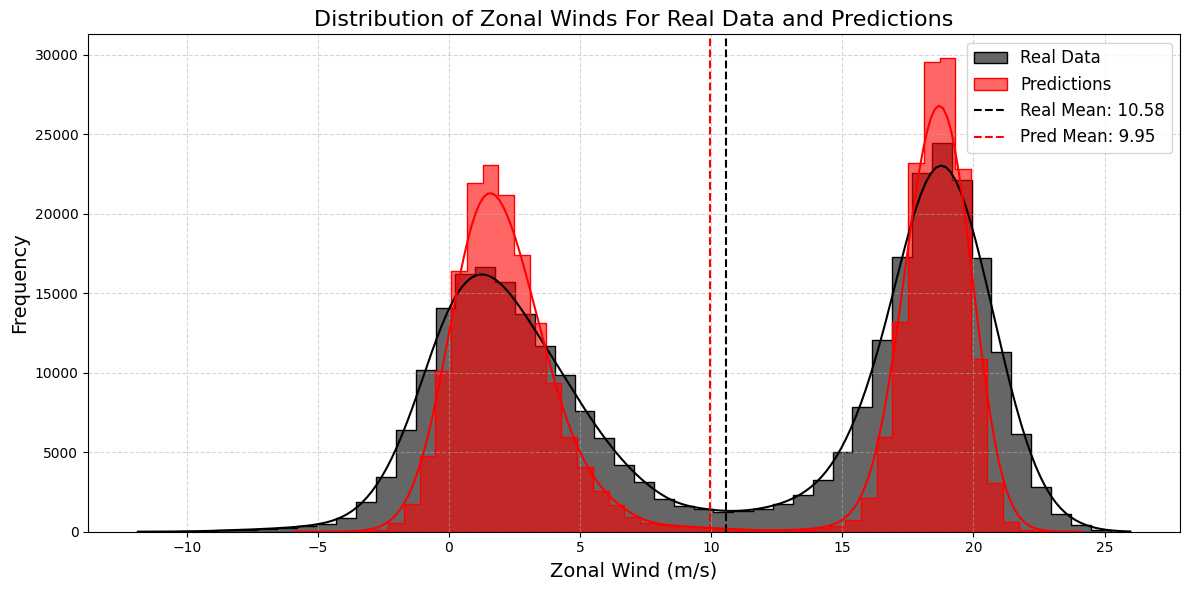

[20000 20001 20002 ... 29997 29998 29999]


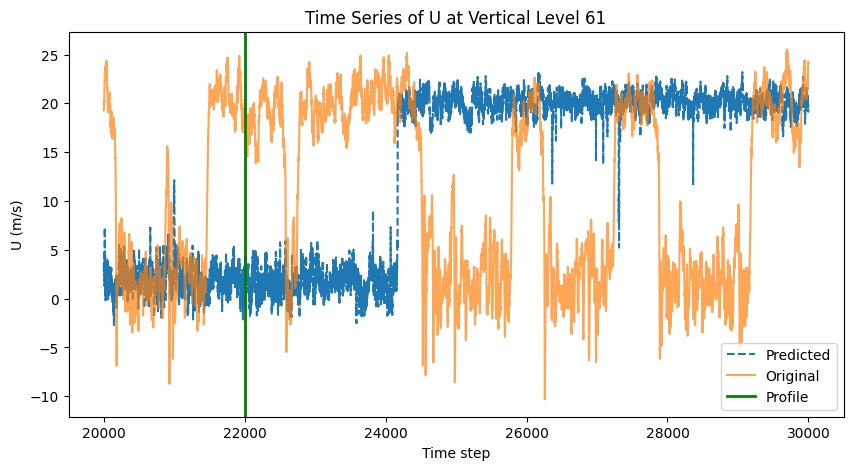

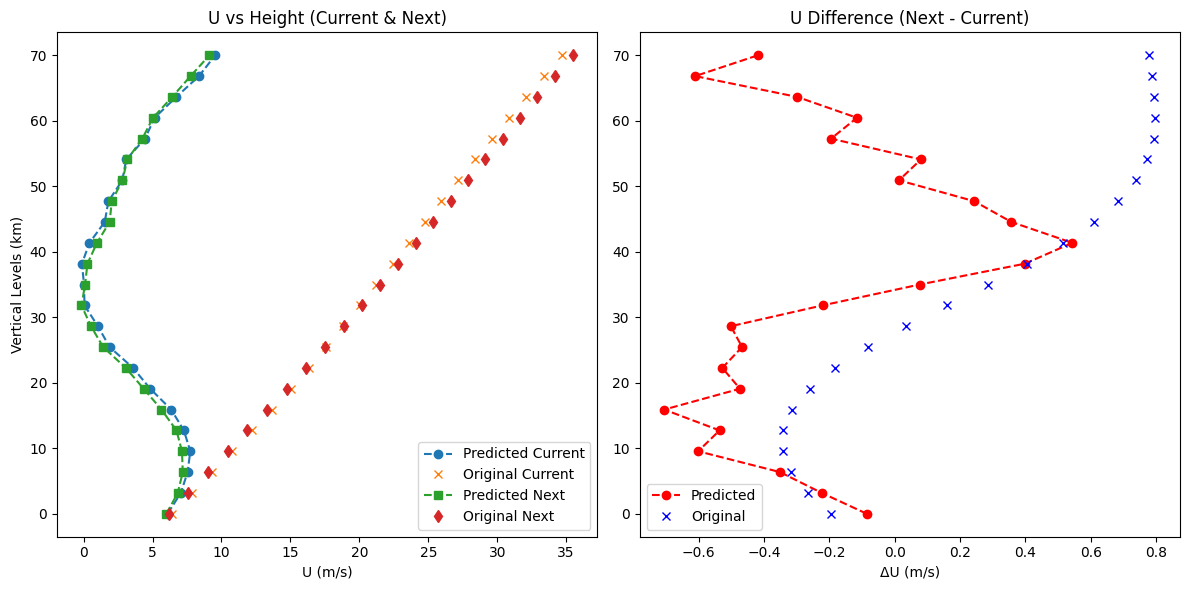

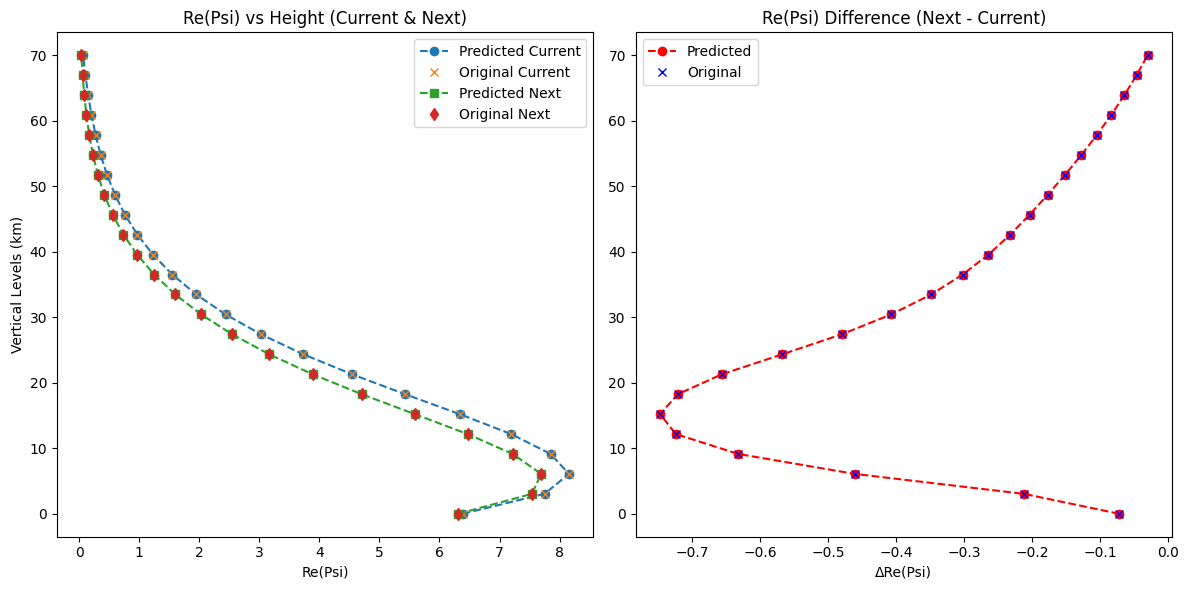

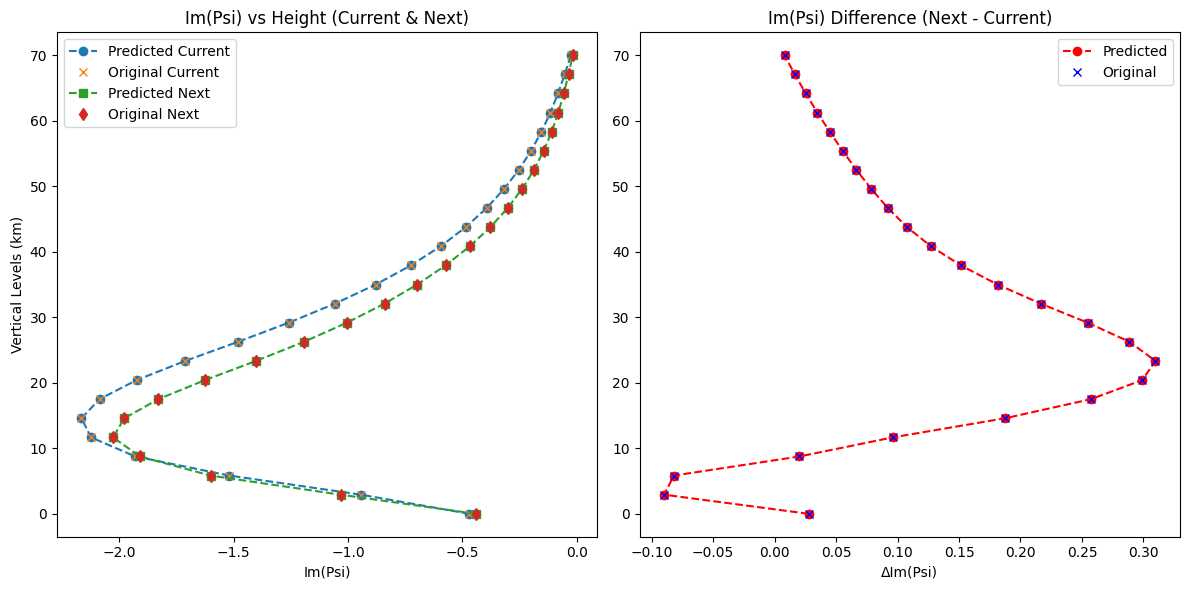

(300000, 1, 75)
(309700, 2, 75)


In [48]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
if (plot_data):
    #note that the value 300000 will have to change depending on the real and predictions data length
    u_profile_real = real_data[:300000, 1, level]  # Match time length with predictions
    u_profile_pred = predictions[:, 0, level]
    time_steps = np.arange(len(u_profile_pred))

    # === Plot ===
    plt.figure(figsize=(14, 6))

    plt.plot(time_steps, u_profile_real, label='Real Data', alpha=0.7)
    plt.plot(time_steps, u_profile_pred, label='Predictions', linestyle='--')


    # Labels, legend, and formatting
    plt.xlabel('Time step')
    plt.ylabel('U (m/s)')
    plt.title(f'Time Series of U at Vertical Level {level}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "timeseries")
    save_path = os.path.join(save_path, "real_prediction_plot")
    plt.savefig(save_path)
    plt.show()

if (CCDF):
    real_data_1d = real_data[:, 1, 61]  # Now shape is (309700,)
    predictions_1d = predictions[:, 0, 61]  # shape (300000,)

    # Define bounds (assuming they apply to both datasets)
    upper_bound = 53.8 / 2.8935
    lower_bound = 1.75 / 2.8935

    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

        valid_indices_real = ccdf_real > 0
        x_fit_real = real_data_sorted[valid_indices_real]
        y_fit_real = np.log(ccdf_real[valid_indices_real])

        slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)

        x_line_real = np.linspace(min(x_fit_real), max(x_fit_real), 100)
        y_line_real = np.exp(slope_real * x_line_real + intercept_real)

        plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
        plt.plot(x_line_real, y_line_real, 'b-', label=f'Real Exp Fit (slope={slope_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)

        x_line_pred = np.linspace(min(x_fit_pred), max(x_fit_pred), 100)
        y_line_pred = np.exp(slope_pred * x_line_pred + intercept_pred)

        plt.step(pred_data_sorted, ccdf_pred, where='post', label='Predictions CCDF', linewidth=2, linestyle='-.', color='red')
        plt.plot(x_line_pred, y_line_pred, 'r-', label=f'Pred Exp Fit (slope={slope_pred:.4f})', linewidth=2)

    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("log")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, "CCDF")
    save_path = os.path.join(save_path, "CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 60]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 0, 60]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    u_profile_pred = predictions[left_limit:right_limit, 0, 61]
    u_profile_original = real_data[left_limit:right_limit, 1, 61]

    # Define time steps
    time_steps = np.arange(left_limit, right_limit)
    print(time_steps)

    # Plot time series
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, u_profile_pred, label="Predicted", linestyle="--")
    plt.plot(time_steps, u_profile_original, label="Original", alpha=0.7)
    plt.axvline(x=time_step, color='green', linestyle='-', linewidth=2, label='Profile')
    plt.xlabel("Time step")
    plt.ylabel("U (m/s)")
    plt.title("Time Series of U at Vertical Level 61")
    plt.legend()
    save_path = os.path.join(folder, "single_step_profiles")
    save_path = os.path.join(save_path, "profile_time_series")
    plt.savefig(save_path)
    plt.show()

    next_time_step = time_step+1

    # Define vertical levels
    z_levels_U = np.linspace(0, 70, 23)
    z_levels_RePsi = np.linspace(0, 70, 24)
    z_levels_ImPsi = np.linspace(0, 70, 25)

    # Extract data for U, Re(Psi), and Im(Psi)
    U_current_pred, U_next_pred = predictions[time_step, 0, 51:74], predictions[next_time_step, 0, 51:74]
    U_current_orig, U_next_orig = real_data[time_step, 1, 51:74], real_data[next_time_step, 1, 51:74]

    RePsi_current_pred, RePsi_next_pred = real_data[time_step, 1, 0:24], real_data[next_time_step, 1, 0:24]
    RePsi_current_orig, RePsi_next_orig = real_data[time_step, 1, 0:24], real_data[next_time_step, 1, 0:24]
    ImPsi_current_pred, ImPsi_next_pred = real_data[time_step, 1, 25:50], real_data[next_time_step, 1, 25:50]
    ImPsi_current_orig, ImPsi_next_orig = real_data[time_step, 1, 25:50], real_data[next_time_step, 1, 25:50]

    # Compute differences
    U_diff_pred, U_diff_orig = U_next_pred - U_current_pred, U_next_orig - U_current_orig
    RePsi_diff_pred, RePsi_diff_orig = RePsi_next_pred - RePsi_current_pred, RePsi_next_orig - RePsi_current_orig
    ImPsi_diff_pred, ImPsi_diff_orig = ImPsi_next_pred - ImPsi_current_pred, ImPsi_next_orig - ImPsi_current_orig


    def plot_variable(ax, pred_current, orig_current, pred_next, orig_next, levels, xlabel, title):
        ax.plot(pred_current, levels, 'o--', label="Predicted Current")
        ax.plot(orig_current, levels, 'x', label="Original Current")
        ax.plot(pred_next, levels, 's--', label="Predicted Next")
        ax.plot(orig_next, levels, 'd', label="Original Next")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Vertical Levels (km)")
        ax.legend()

    def plot_difference(ax, diff_pred, diff_orig, levels, xlabel, title):
        ax.plot(diff_pred, levels, 'o--r', label="Predicted")
        ax.plot(diff_orig, levels, 'xb', label="Original")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.legend()

    # --- 2A. U Comparison Plot (Save in 'zonal_wind') ---
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_variable(axes[0], U_current_pred, U_current_orig, U_next_pred, U_next_orig,
                z_levels_U, "U (m/s)", "U vs Height (Current & Next)")
    plot_difference(axes[1], U_diff_pred, U_diff_orig, z_levels_U,
                    "ΔU (m/s)", "U Difference (Next - Current)")
    plt.tight_layout()
    save_path = os.path.join(folder, "single_step_profiles")
    save_path = os.path.join(save_path, "zonal_wind")
    save_path = os.path.join(save_path, "U_profile")
    plt.savefig(save_path)
    plt.show()

    # --- 2B. Re(Psi) Comparison Plot (Save in 'real_psi') ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_variable(axes[0], RePsi_current_pred, RePsi_current_orig, RePsi_next_pred, RePsi_next_orig,
                z_levels_RePsi, "Re(Psi)", "Re(Psi) vs Height (Current & Next)")
    plot_difference(axes[1], RePsi_diff_pred, RePsi_diff_orig, z_levels_RePsi,
                    "ΔRe(Psi)", "Re(Psi) Difference (Next - Current)")
    plt.tight_layout()
    save_path = os.path.join(folder, "single_step_profiles")
    save_path = os.path.join(save_path, "real_psi")
    save_path = os.path.join(save_path, "repsi_profile")
    plt.savefig(save_path)
    plt.show()

    # --- 2C. Im(Psi) Comparison Plot (Save in 'im_psi') ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_variable(axes[0], ImPsi_current_pred, ImPsi_current_orig, ImPsi_next_pred, ImPsi_next_orig,
                z_levels_ImPsi, "Im(Psi)", "Im(Psi) vs Height (Current & Next)")
    plot_difference(axes[1], ImPsi_diff_pred, ImPsi_diff_orig, z_levels_ImPsi,
                    "ΔIm(Psi)", "Im(Psi) Difference (Next - Current)")
    plt.tight_layout()
    save_path = os.path.join(folder, "single_step_profiles")
    save_path = os.path.join(save_path, "im_psi")
    save_path = os.path.join(save_path, "impsi_profile")
    plt.savefig(save_path)
    plt.show()

    # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)